# VAE for MNIST clustering and generation

The goal of this notebook is to explore some recent works dealing with variational auto-encoder (VAE).

We will use MNIST dataset and a basic VAE architecture. 

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.cluster import normalized_mutual_info_score

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
def plot_reconstruction(model, n=24):
    x,_ = next(iter(data_loader))
    x = x[:n,:,:,:].to(device)
    try:
        out, _, _, log_p = model(x.view(-1, image_size)) 
    except:
        out, _, _ = model(x.view(-1, image_size)) 
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
    out_grid = torchvision.utils.make_grid(x_concat).cpu().data
    show(out_grid)

def plot_generation(model, n=24):
    with torch.no_grad():
        z = torch.randn(n, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

def plot_conditional_generation(model, n=8, fix_number=None):
    with torch.no_grad():
        matrix = np.zeros((n,n_classes))
        matrix[:,0] = 1

        if fix_number is None:
            final = matrix[:]
            for i in range(1,n_classes):
                final = np.vstack((final,np.roll(matrix,i)))
            z = torch.randn(8*n_classes, z_dim).to(device)
            y_onehot = torch.tensor(final).type(torch.FloatTensor).to(device)
            out = model_G.decode(z,y_onehot).view(-1, 1, 28, 28)
        else:
            z = torch.randn(n, z_dim).to(device)
            y_onehot = torch.tensor(np.roll(matrix, fix_number)).type(torch.FloatTensor).to(device)
            out = model_G.decode(z,y_onehot).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [4]:
batch_size = 128

data_dir = 'data'
# MNIST dataset
dataset = torchvision.datasets.MNIST(root=data_dir,
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

HBox(children=(FloatProgress(value=1.0, bar_style='info', layout=Layout(width='20px'), max=1.0), HTML(value='')))

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


HBox(children=(FloatProgress(value=1.0, bar_style='info', layout=Layout(width='20px'), max=1.0), HTML(value='')))

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


HBox(children=(FloatProgress(value=1.0, bar_style='info', layout=Layout(width='20px'), max=1.0), HTML(value='')))

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


HBox(children=(FloatProgress(value=1.0, bar_style='info', layout=Layout(width='20px'), max=1.0), HTML(value='')))

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/Users/megidervishi/anaconda3/lib/python3.6/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Variational Autoencoders

Consider a latent variable model with a data variable $x\in \mathcal{X}$ and a latent variable $z\in \mathcal{Z}$, $p(z,x) = p(z)p_\theta(x|z)$. Given the data $x_1,\dots, x_n$, we want to train the model by maximizing the marginal log-likelihood:
\begin{eqnarray*}
\mathcal{L} = \mathbf{E}_{p_d(x)}\left[\log p_\theta(x)\right]=\mathbf{E}_{p_d(x)}\left[\log \int_{\mathcal{Z}}p_{\theta}(x|z)p(z)dz\right],
  \end{eqnarray*}
  where $p_d$ denotes the empirical distribution of $X$: $p_d(x) =\frac{1}{n}\sum_{i=1}^n \delta_{x_i}(x)$.

 To avoid the (often) difficult computation of the integral above, the idea behind variational methods is to instead maximize a lower bound to the log-likelihood:
  \begin{eqnarray*}
\mathcal{L} \geq L(p_\theta(x|z),q(z|x)) =\mathbf{E}_{p_d(x)}\left[\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]-\mathrm{KL}\left( q(z|x)||p(z)\right)\right].
  \end{eqnarray*}
  Any choice of $q(z|x)$ gives a valid lower bound. Variational autoencoders replace the variational posterior $q(z|x)$ by an inference network $q_{\phi}(z|x)$ that is trained together with $p_{\theta}(x|z)$ to jointly maximize $L(p_\theta,q_\phi)$.
  
The variational posterior $q_{\phi}(z|x)$ is also called the **encoder** and the generative model $p_{\theta}(x|z)$, the **decoder** or generator.

The first term $\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]$ is the negative reconstruction error. Indeed under a gaussian assumption i.e. $p_{\theta}(x|z) = \mathcal{N}(\mu_{\theta}(z), I)$ the term $\log p_\theta(x|z)$ reduces to $\propto \|x-\mu_\theta(z)\|^2$, which is often used in practice. The term $\mathrm{KL}\left( q(z|x)||p(z)\right)$ can be seen as a regularization term, where the variational posterior $q_\phi(z|x)$ should be matched to the prior $p(z)= \mathcal{N}(0, I)$.

Variational Autoencoders were introduced by [Kingma and Welling (2013)](https://arxiv.org/abs/1312.6114), see also [(Doersch, 2016)](https://arxiv.org/abs/1606.05908) for a tutorial.

There are various examples of VAE in PyTorch available [here](https://github.com/pytorch/examples/tree/master/vae?raw=1) or [here](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/variational_autoencoder/main.py#L38-L65). The code below is taken from this last source.

![A variational autoencoder.](https://github.com/MegiDervishi/notebooks/blob/master/HW3/vae.png)

In [5]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
learning_rate = 1e-3

# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Here for the loss, instead of MSE for the reconstruction loss, we take Binary Cross-Entropy. The code below is still from the PyTorch tutorial (with minor modifications to avoid warnings!).

In [6]:
# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
        # https://arxiv.org/abs/1606.05908
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size, kl_div.item()/batch_size))

Epoch[1/15], Step [10/469], Reconst Loss: 283.4444, KL Div: 30.6976
Epoch[1/15], Step [20/469], Reconst Loss: 227.9601, KL Div: 8.2261
Epoch[1/15], Step [30/469], Reconst Loss: 212.8159, KL Div: 9.0650
Epoch[1/15], Step [40/469], Reconst Loss: 207.7409, KL Div: 5.5895
Epoch[1/15], Step [50/469], Reconst Loss: 206.4438, KL Div: 5.5463
Epoch[1/15], Step [60/469], Reconst Loss: 187.1308, KL Div: 8.9796
Epoch[1/15], Step [70/469], Reconst Loss: 191.9458, KL Div: 7.0730
Epoch[1/15], Step [80/469], Reconst Loss: 192.5746, KL Div: 7.5109
Epoch[1/15], Step [90/469], Reconst Loss: 168.9218, KL Div: 10.4938
Epoch[1/15], Step [100/469], Reconst Loss: 172.0278, KL Div: 11.4910
Epoch[1/15], Step [110/469], Reconst Loss: 174.3038, KL Div: 11.2750
Epoch[1/15], Step [120/469], Reconst Loss: 156.0820, KL Div: 12.8584
Epoch[1/15], Step [130/469], Reconst Loss: 158.1327, KL Div: 14.0804
Epoch[1/15], Step [140/469], Reconst Loss: 156.8378, KL Div: 13.2619
Epoch[1/15], Step [150/469], Reconst Loss: 140.676

Epoch[3/15], Step [310/469], Reconst Loss: 89.2087, KL Div: 24.4912
Epoch[3/15], Step [320/469], Reconst Loss: 89.1233, KL Div: 24.5143
Epoch[3/15], Step [330/469], Reconst Loss: 85.4465, KL Div: 24.3192
Epoch[3/15], Step [340/469], Reconst Loss: 92.9438, KL Div: 24.4922
Epoch[3/15], Step [350/469], Reconst Loss: 91.7630, KL Div: 24.3071
Epoch[3/15], Step [360/469], Reconst Loss: 89.6768, KL Div: 24.7731
Epoch[3/15], Step [370/469], Reconst Loss: 90.3116, KL Div: 24.9383
Epoch[3/15], Step [380/469], Reconst Loss: 88.5050, KL Div: 24.6078
Epoch[3/15], Step [390/469], Reconst Loss: 87.3001, KL Div: 24.2962
Epoch[3/15], Step [400/469], Reconst Loss: 90.1058, KL Div: 24.6141
Epoch[3/15], Step [410/469], Reconst Loss: 86.3154, KL Div: 23.5284
Epoch[3/15], Step [420/469], Reconst Loss: 91.4078, KL Div: 24.1764
Epoch[3/15], Step [430/469], Reconst Loss: 88.7384, KL Div: 23.4781
Epoch[3/15], Step [440/469], Reconst Loss: 86.8329, KL Div: 24.4642
Epoch[3/15], Step [450/469], Reconst Loss: 87.28

Epoch[6/15], Step [150/469], Reconst Loss: 81.9854, KL Div: 24.5616
Epoch[6/15], Step [160/469], Reconst Loss: 83.6724, KL Div: 25.3713
Epoch[6/15], Step [170/469], Reconst Loss: 85.4816, KL Div: 25.2363
Epoch[6/15], Step [180/469], Reconst Loss: 80.2557, KL Div: 24.4230
Epoch[6/15], Step [190/469], Reconst Loss: 85.7166, KL Div: 24.2247
Epoch[6/15], Step [200/469], Reconst Loss: 82.0852, KL Div: 25.3454
Epoch[6/15], Step [210/469], Reconst Loss: 83.4794, KL Div: 24.0721
Epoch[6/15], Step [220/469], Reconst Loss: 84.8882, KL Div: 24.9672
Epoch[6/15], Step [230/469], Reconst Loss: 86.1325, KL Div: 24.9857
Epoch[6/15], Step [240/469], Reconst Loss: 85.4666, KL Div: 25.0496
Epoch[6/15], Step [250/469], Reconst Loss: 84.5038, KL Div: 24.8124
Epoch[6/15], Step [260/469], Reconst Loss: 85.6003, KL Div: 24.9404
Epoch[6/15], Step [270/469], Reconst Loss: 79.3931, KL Div: 25.1200
Epoch[6/15], Step [280/469], Reconst Loss: 83.3944, KL Div: 25.6857
Epoch[6/15], Step [290/469], Reconst Loss: 85.40

Epoch[8/15], Step [450/469], Reconst Loss: 80.9998, KL Div: 24.9318
Epoch[8/15], Step [460/469], Reconst Loss: 82.1973, KL Div: 24.5933
Epoch[9/15], Step [10/469], Reconst Loss: 79.0835, KL Div: 24.9193
Epoch[9/15], Step [20/469], Reconst Loss: 80.8568, KL Div: 25.3240
Epoch[9/15], Step [30/469], Reconst Loss: 84.1270, KL Div: 25.5732
Epoch[9/15], Step [40/469], Reconst Loss: 82.5442, KL Div: 25.0875
Epoch[9/15], Step [50/469], Reconst Loss: 87.6259, KL Div: 25.5161
Epoch[9/15], Step [60/469], Reconst Loss: 78.7696, KL Div: 24.7656
Epoch[9/15], Step [70/469], Reconst Loss: 82.7669, KL Div: 26.9254
Epoch[9/15], Step [80/469], Reconst Loss: 81.0623, KL Div: 24.7591
Epoch[9/15], Step [90/469], Reconst Loss: 77.6811, KL Div: 24.1094
Epoch[9/15], Step [100/469], Reconst Loss: 84.9075, KL Div: 25.9289
Epoch[9/15], Step [110/469], Reconst Loss: 78.6138, KL Div: 25.1645
Epoch[9/15], Step [120/469], Reconst Loss: 81.9030, KL Div: 25.2650
Epoch[9/15], Step [130/469], Reconst Loss: 80.6560, KL Di

Epoch[11/15], Step [280/469], Reconst Loss: 81.4550, KL Div: 25.3725
Epoch[11/15], Step [290/469], Reconst Loss: 77.6456, KL Div: 25.0046
Epoch[11/15], Step [300/469], Reconst Loss: 83.6936, KL Div: 25.0141
Epoch[11/15], Step [310/469], Reconst Loss: 78.7763, KL Div: 25.4609
Epoch[11/15], Step [320/469], Reconst Loss: 79.4224, KL Div: 25.6144
Epoch[11/15], Step [330/469], Reconst Loss: 79.2705, KL Div: 24.6755
Epoch[11/15], Step [340/469], Reconst Loss: 79.8311, KL Div: 25.1374
Epoch[11/15], Step [350/469], Reconst Loss: 83.1249, KL Div: 25.3839
Epoch[11/15], Step [360/469], Reconst Loss: 79.9598, KL Div: 25.2443
Epoch[11/15], Step [370/469], Reconst Loss: 81.0097, KL Div: 25.9255
Epoch[11/15], Step [380/469], Reconst Loss: 80.6209, KL Div: 25.8971
Epoch[11/15], Step [390/469], Reconst Loss: 80.7376, KL Div: 25.0892
Epoch[11/15], Step [400/469], Reconst Loss: 80.7466, KL Div: 25.7320
Epoch[11/15], Step [410/469], Reconst Loss: 81.4588, KL Div: 25.9351
Epoch[11/15], Step [420/469], Reco

Epoch[14/15], Step [110/469], Reconst Loss: 77.7710, KL Div: 25.6365
Epoch[14/15], Step [120/469], Reconst Loss: 79.4527, KL Div: 26.0826
Epoch[14/15], Step [130/469], Reconst Loss: 79.4439, KL Div: 25.4844
Epoch[14/15], Step [140/469], Reconst Loss: 83.2154, KL Div: 26.0082
Epoch[14/15], Step [150/469], Reconst Loss: 78.8878, KL Div: 25.3778
Epoch[14/15], Step [160/469], Reconst Loss: 78.6515, KL Div: 25.2636
Epoch[14/15], Step [170/469], Reconst Loss: 75.8635, KL Div: 24.7826
Epoch[14/15], Step [180/469], Reconst Loss: 79.3048, KL Div: 25.2690
Epoch[14/15], Step [190/469], Reconst Loss: 78.2646, KL Div: 25.3400
Epoch[14/15], Step [200/469], Reconst Loss: 77.3817, KL Div: 25.7637
Epoch[14/15], Step [210/469], Reconst Loss: 78.9489, KL Div: 25.5684
Epoch[14/15], Step [220/469], Reconst Loss: 77.7267, KL Div: 25.7162
Epoch[14/15], Step [230/469], Reconst Loss: 77.3374, KL Div: 25.2003
Epoch[14/15], Step [240/469], Reconst Loss: 78.6105, KL Div: 25.5992
Epoch[14/15], Step [250/469], Reco

Let see how our network reconstructs our last batch. We display pairs of original digits and reconstructed version.

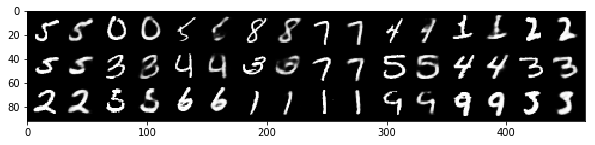

In [7]:
plt.figure(figsize=(10,5))
plot_reconstruction(model)

Let's see now how our network generates new samples.

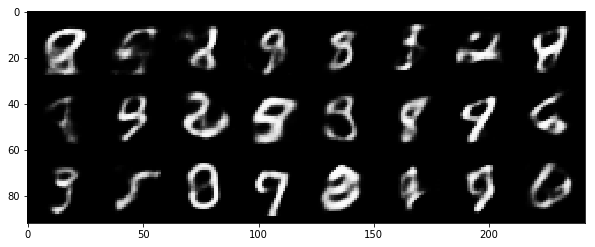

In [8]:
plt.figure(figsize=(10,5))
plot_generation(model)

Not great, but we did not train our network for long... That being said, we have no control of the generated digits. In the rest of this notebook, we explore ways to generates zeroes, ones, twos and so on. As a by-product, we show how our VAE will allow us to do clustering.

The main idea is to build what we call a Gumbel VAE as described below.

# Gumbel VAE

Implement a VAE where you add a categorical variable $c\in \{0,\dots 9\}$ so that your latent variable model is $p(c,z,x) = p(c)p(z)p_{\theta}(x|,c,z)$ and your variational posterior is $q_{\phi}(c|x)q_{\phi}(z|x)$ as described in this NeurIPS paper: [(Dupont, 2018)](https://arxiv.org/abs/1804.00104). Make minimal modifications to previous architecture.

The idea is to incorporate a categorical variable in your latent space. You hope that this categorical variable will encode the class of the digit, so that your network can use it for a better reconstruction. Moreover, if things work as planned, you will then be able to generate digits conditionally to the class, i.e. you can choose the class thanks to the latent categorical variable $c$ and then generate digits from this class.

As noticed above, in order to sample random variables while still being able to use backpropagation, we need to use the reparameterization trick which is easy for Gaussian random variables. For categorical random variables, the reparameterization trick is explained in [(Jang et al., 2016)](https://arxiv.org/abs/1611.01144). This is implemented in PyTorch thanks to [F.gumbel_softmax](https://pytorch.org/docs/stable/nn.html?highlight=gumbel_softmax#torch.nn.functional.gumbel_softmax).

In [9]:
n_classes = 10

class VAE_Gumbel(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20, n_classes = 10):
        super(VAE_Gumbel, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(h_dim, n_classes)
        self.fc5 = nn.Linear(z_dim + n_classes , h_dim)
        self.fc6 = nn.Linear(h_dim, image_size)
        
        
    def encode(self, x):
        # use F.log_softmax
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h), F.log_softmax(self.fc4(h), dim=1)
        
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y_onehot):
        # use torch.cat 
        zy = torch.cat((z, y_onehot), dim =1)
        h = F.relu(self.fc5(zy))
        return torch.sigmoid(self.fc6(h))
        
    
    def forward(self, x):
        # use F.gumbel_softmax
        mu, log_var, alpha = self.encode(x)
        z = self.reparameterize(mu, log_var)
        y_onehot = F.gumbel_softmax(alpha, tau=0.5)
        x_reconst = self.decode(z, y_onehot)
        return x_reconst, mu, log_var, y_onehot
        

model_G = VAE_Gumbel().to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

You need to modify the loss to take into account the categorical random variable with an uniform prior on $\{0,\dots 9\}$, see Appendix A.2 in [(Dupont, 2018)](https://arxiv.org/abs/1804.00104)

## EXPLAIN: 
From the paper:
$$D_{\mathrm{KL}}\left( q_{\phi}(z|c,
x)||p(z,c)\right) = D_{\mathrm{KL}}\left( q_{\phi}(z|x)||p(z)\right) + D_{\mathrm{KL}}\left( q_{\phi}(c|x)||p(c)\right)$$

$$D_{\mathrm{KL}}\left( q_{\phi}(z|x)||p(z)\right) = -\frac{1}{2} \sum _j(1 + \log(\sigma_j) - \mu_j^2 - \sigma_j^2 ) $$

$c \sim g(\alpha)$ where $g$ is Gumbel softmax distribution. 
$p(c)$ follows a Uniform Gumbel Softmax distribution. Hence in our case $p(c = 0) = \frac{1}{{n_{classes}}}$. We also have that $q_{\phi}(c|x)$ is a categorial random variable. Hence:

\begin{align} D_{\mathrm{KL}}\left( q_{\phi}(c|x)||p(c)\right) &= \sum_{i=1}^{n_{classes}} q_{i} \log \frac{q_i}{p_i} \\ &= \sum_{i=1}^{n_{classes}} q_i \log \frac{q_i}{1/n_{classes}} \\ &= \sum_{i=1}^{n_{classes}} q_i \log q_i + \sum_{i=1}^{n_{classes}} q_i\log n_{classes} \\ &= -H(q_{\phi}(c|x)) + \log(n_{classes})
\end{align}


we know that $q_i$ is returned by the model `g_alpha` and $p_i = 1/{n_{classes}}$ so we can compute the above straightforward. 




In [10]:
def train_G(model, data_loader=data_loader,num_epochs=num_epochs, beta = 1., verbose=True):
    nmi_scores = []
    model.train(True)
    for epoch in range(num_epochs):
        all_labels = []
        all_labels_est = []
        for i, (x, labels) in enumerate(data_loader):
            
            # Forward pass
            x = x.to(device).view(-1, image_size)
            x_reconst, mu, log_var, g_alpha = model(x)
            
            #NMI
            all_labels += labels.tolist()
            all_labels_est += torch.argmax(g_alpha, dim=1).tolist()
            
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            KL_div_z = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            pi = torch.tensor([1/n_classes], device=device)
            H_cat = - torch.sum(g_alpha * g_alpha.log(), dim=1) #entropy
            KL_div_c = torch.sum(-H_cat - torch.log(pi))#expectency
            H_cat = torch.sum(H_cat) #helps for the print
            
            KL_div = KL_div_z + KL_div_c

            # Backprop and optimize
            loss = reconst_loss + beta*KL_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                if (i+1) % 10 == 0:
                    print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, kl_div_c: {:.4f}, Entropy: {:.4f}" 
                           .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size,
                                   KL_div.item()/batch_size, KL_div_c.item()/batch_size, H_cat.item()/batch_size))
    
        nmi = normalized_mutual_info_score(all_labels, all_labels_est)
        nmi_scores.append(nmi)
    return nmi_scores

In [11]:
nmi = train_G(model_G,num_epochs=10,verbose=True)

Epoch[1/10], Step [10/469], Reconst Loss: 295.8097, KL Div: 26.3921, kl_div_c: 1.4442, Entropy: 0.8584
Epoch[1/10], Step [20/469], Reconst Loss: 237.9132, KL Div: 11.6071, kl_div_c: 1.5115, Entropy: 0.7911
Epoch[1/10], Step [30/469], Reconst Loss: 214.0738, KL Div: 12.1082, kl_div_c: 1.5578, Entropy: 0.7448
Epoch[1/10], Step [40/469], Reconst Loss: 210.5674, KL Div: 6.6489, kl_div_c: 1.5111, Entropy: 0.7915
Epoch[1/10], Step [50/469], Reconst Loss: 207.7448, KL Div: 7.2551, kl_div_c: 1.4965, Entropy: 0.8061
Epoch[1/10], Step [60/469], Reconst Loss: 196.2546, KL Div: 7.8084, kl_div_c: 1.5598, Entropy: 0.7428
Epoch[1/10], Step [70/469], Reconst Loss: 198.5005, KL Div: 7.8504, kl_div_c: 1.4972, Entropy: 0.8054
Epoch[1/10], Step [80/469], Reconst Loss: 193.8957, KL Div: 8.8493, kl_div_c: 1.5796, Entropy: 0.7230
Epoch[1/10], Step [90/469], Reconst Loss: 179.6999, KL Div: 10.7978, kl_div_c: 1.5632, Entropy: 0.7394
Epoch[1/10], Step [100/469], Reconst Loss: 182.9502, KL Div: 11.5317, kl_div_c

Epoch[2/10], Step [350/469], Reconst Loss: 95.5485, KL Div: 24.1051, kl_div_c: 1.5198, Entropy: 0.7828
Epoch[2/10], Step [360/469], Reconst Loss: 91.5845, KL Div: 24.3046, kl_div_c: 1.6097, Entropy: 0.6929
Epoch[2/10], Step [370/469], Reconst Loss: 94.5486, KL Div: 24.0813, kl_div_c: 1.6275, Entropy: 0.6750
Epoch[2/10], Step [380/469], Reconst Loss: 98.0099, KL Div: 24.5214, kl_div_c: 1.6182, Entropy: 0.6843
Epoch[2/10], Step [390/469], Reconst Loss: 96.9200, KL Div: 24.1616, kl_div_c: 1.6085, Entropy: 0.6940
Epoch[2/10], Step [400/469], Reconst Loss: 96.7135, KL Div: 23.9197, kl_div_c: 1.5738, Entropy: 0.7288
Epoch[2/10], Step [410/469], Reconst Loss: 98.1384, KL Div: 25.1735, kl_div_c: 1.6148, Entropy: 0.6878
Epoch[2/10], Step [420/469], Reconst Loss: 95.2170, KL Div: 24.2239, kl_div_c: 1.5883, Entropy: 0.7142
Epoch[2/10], Step [430/469], Reconst Loss: 94.0985, KL Div: 24.2298, kl_div_c: 1.6604, Entropy: 0.6422
Epoch[2/10], Step [440/469], Reconst Loss: 92.5431, KL Div: 24.4869, kl_d

Epoch[4/10], Step [240/469], Reconst Loss: 90.0244, KL Div: 26.0645, kl_div_c: 1.6203, Entropy: 0.6823
Epoch[4/10], Step [250/469], Reconst Loss: 87.9486, KL Div: 25.8408, kl_div_c: 1.5021, Entropy: 0.8005
Epoch[4/10], Step [260/469], Reconst Loss: 85.3125, KL Div: 24.9394, kl_div_c: 1.5895, Entropy: 0.7131
Epoch[4/10], Step [270/469], Reconst Loss: 83.9700, KL Div: 26.6745, kl_div_c: 1.5101, Entropy: 0.7925
Epoch[4/10], Step [280/469], Reconst Loss: 84.8126, KL Div: 24.6888, kl_div_c: 1.6225, Entropy: 0.6800
Epoch[4/10], Step [290/469], Reconst Loss: 88.3761, KL Div: 26.2917, kl_div_c: 1.5825, Entropy: 0.7200
Epoch[4/10], Step [300/469], Reconst Loss: 90.2729, KL Div: 26.6937, kl_div_c: 1.5880, Entropy: 0.7145
Epoch[4/10], Step [310/469], Reconst Loss: 83.3308, KL Div: 25.1734, kl_div_c: 1.5839, Entropy: 0.7187
Epoch[4/10], Step [320/469], Reconst Loss: 85.9036, KL Div: 24.7941, kl_div_c: 1.5232, Entropy: 0.7794
Epoch[4/10], Step [330/469], Reconst Loss: 84.9798, KL Div: 25.7846, kl_d

Epoch[6/10], Step [130/469], Reconst Loss: 87.0957, KL Div: 26.6882, kl_div_c: 1.6399, Entropy: 0.6626
Epoch[6/10], Step [140/469], Reconst Loss: 84.6365, KL Div: 26.5954, kl_div_c: 1.6177, Entropy: 0.6849
Epoch[6/10], Step [150/469], Reconst Loss: 86.4093, KL Div: 25.9136, kl_div_c: 1.7023, Entropy: 0.6003
Epoch[6/10], Step [160/469], Reconst Loss: 84.3710, KL Div: 26.3856, kl_div_c: 1.6617, Entropy: 0.6409
Epoch[6/10], Step [170/469], Reconst Loss: 80.7053, KL Div: 25.6782, kl_div_c: 1.6058, Entropy: 0.6968
Epoch[6/10], Step [180/469], Reconst Loss: 84.8329, KL Div: 26.0547, kl_div_c: 1.6769, Entropy: 0.6257
Epoch[6/10], Step [190/469], Reconst Loss: 85.6038, KL Div: 25.8590, kl_div_c: 1.6467, Entropy: 0.6559
Epoch[6/10], Step [200/469], Reconst Loss: 82.1713, KL Div: 25.7958, kl_div_c: 1.6271, Entropy: 0.6755
Epoch[6/10], Step [210/469], Reconst Loss: 85.0586, KL Div: 26.4007, kl_div_c: 1.5949, Entropy: 0.7077
Epoch[6/10], Step [220/469], Reconst Loss: 80.6312, KL Div: 25.2151, kl_d

Epoch[8/10], Step [10/469], Reconst Loss: 79.3101, KL Div: 25.7539, kl_div_c: 1.6518, Entropy: 0.6508
Epoch[8/10], Step [20/469], Reconst Loss: 86.0751, KL Div: 26.0924, kl_div_c: 1.7144, Entropy: 0.5882
Epoch[8/10], Step [30/469], Reconst Loss: 81.2953, KL Div: 25.9641, kl_div_c: 1.6953, Entropy: 0.6073
Epoch[8/10], Step [40/469], Reconst Loss: 84.7822, KL Div: 26.2986, kl_div_c: 1.6304, Entropy: 0.6722
Epoch[8/10], Step [50/469], Reconst Loss: 81.8291, KL Div: 26.4819, kl_div_c: 1.6079, Entropy: 0.6946
Epoch[8/10], Step [60/469], Reconst Loss: 86.2114, KL Div: 26.5420, kl_div_c: 1.6909, Entropy: 0.6117
Epoch[8/10], Step [70/469], Reconst Loss: 83.8712, KL Div: 26.1399, kl_div_c: 1.7262, Entropy: 0.5764
Epoch[8/10], Step [80/469], Reconst Loss: 83.1733, KL Div: 25.9746, kl_div_c: 1.8151, Entropy: 0.4875
Epoch[8/10], Step [90/469], Reconst Loss: 80.7502, KL Div: 26.0485, kl_div_c: 1.6774, Entropy: 0.6252
Epoch[8/10], Step [100/469], Reconst Loss: 80.9986, KL Div: 26.3387, kl_div_c: 1.7

Epoch[9/10], Step [350/469], Reconst Loss: 79.6441, KL Div: 26.0941, kl_div_c: 1.6748, Entropy: 0.6277
Epoch[9/10], Step [360/469], Reconst Loss: 81.6610, KL Div: 26.3258, kl_div_c: 1.8006, Entropy: 0.5020
Epoch[9/10], Step [370/469], Reconst Loss: 83.0548, KL Div: 27.4775, kl_div_c: 1.8058, Entropy: 0.4968
Epoch[9/10], Step [380/469], Reconst Loss: 84.5611, KL Div: 26.4529, kl_div_c: 1.8067, Entropy: 0.4959
Epoch[9/10], Step [390/469], Reconst Loss: 81.7165, KL Div: 25.9372, kl_div_c: 1.7128, Entropy: 0.5898
Epoch[9/10], Step [400/469], Reconst Loss: 81.2576, KL Div: 26.3591, kl_div_c: 1.7227, Entropy: 0.5799
Epoch[9/10], Step [410/469], Reconst Loss: 81.3379, KL Div: 25.9060, kl_div_c: 1.7223, Entropy: 0.5803
Epoch[9/10], Step [420/469], Reconst Loss: 78.8244, KL Div: 26.3701, kl_div_c: 1.7572, Entropy: 0.5454
Epoch[9/10], Step [430/469], Reconst Loss: 79.6145, KL Div: 25.8130, kl_div_c: 1.7361, Entropy: 0.5665
Epoch[9/10], Step [440/469], Reconst Loss: 82.9903, KL Div: 26.5819, kl_d

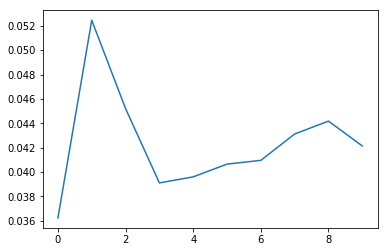

In [12]:
plt.plot(nmi)
plt.show()

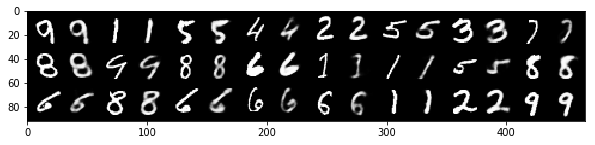

In [13]:
plt.figure(figsize=(10,5))
plot_reconstruction(model_G)

This was for reconstruction, but we care more about generation. For each category, we are generating 8 samples thanks to the `plot_conditional_generation()` function.

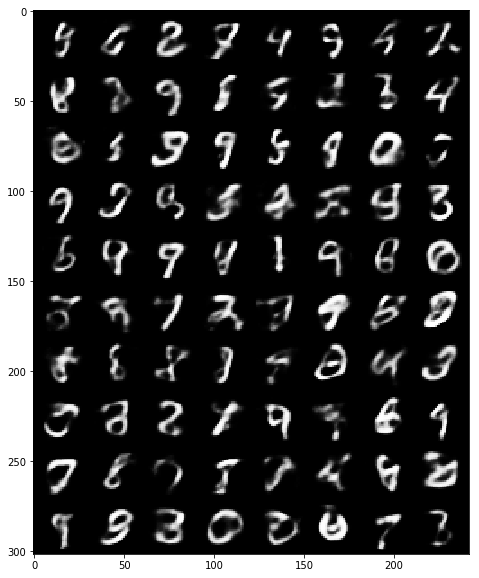

In [14]:
plt.figure(figsize=(10,10))
plot_conditional_generation(model_G, n=8)

It does not look like our original idea is working...

What is happening is that our network is not using the categorical variable. We can track the [normalized mutual information](https://en.wikipedia.org/wiki/Mutual_information#Normalized_variants) (see [this method in scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html)) between the true labels and the labels predicted by our network (just by taking the category with maximal probability). 

Change your training loop to return the normalized mutual information (NMI) for each epoch. Plot the curve to check that the NMI is actually decreasing.

This problem is explained in [(Burgess et al., 2018)](https://arxiv.org/abs/1804.03599) and a solution is proposed in Section 5.

In order to force our network to use the categorical variable, we will change the loss according to [(Dupont, 2018)](https://arxiv.org/abs/1804.00104), Section 3 Equation (7).

Implement this change in the training loop and plot the new NMI curve. For $\beta = 20, C_z=100, C_c=100$, you should see that NMI increases.

In [15]:
model_G = VAE_Gumbel().to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

In [16]:
def train_G_modified_loss(model, data_loader=data_loader,num_epochs=num_epochs, beta = 20, C_z_fin=100, C_c_fin=100, verbose=True):
    #progress of C
    Cz = np.linspace(0, C_z_fin, num_epochs*len(data_loader))
    Cc = np.linspace(0, C_c_fin, num_epochs*len(data_loader))
    nmi_scores = []
    model.train(True)
    for epoch in range(num_epochs):
        all_labels = []
        all_labels_est = []
        for i, (x, labels) in enumerate(data_loader):
            
            # Forward pass
            x = x.to(device).view(-1, image_size)
            x_reconst, mu, log_var, g_alpha = model(x)
            
            #NMI
            all_labels += labels.tolist()
            all_labels_est += torch.argmax(g_alpha, dim=1).tolist()
            
            #update C
            cz_i = Cz[epoch * len(data_loader) + i]
            cc_i = Cc[epoch * len(data_loader) + i]
            
            #compute KL+reconst_loss
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            KL_div_z = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            pi = torch.tensor([1/n_classes], device=device)
            H_cat = - torch.sum(g_alpha * g_alpha.log(), dim=1) #entropy
            KL_div_c = torch.sum(-H_cat - torch.log(pi))#expectency
            H_cat = torch.sum(H_cat) #print
            
            KL_div = torch.abs(KL_div_z - cz_i) + torch.abs(KL_div_c - cc_i)

            # Backprop and optimize
            loss = reconst_loss + beta * KL_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                if (i+1) % 10 == 0:
                    print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, kl_div_c: {:.4f}, Entropy: {:.4f}" 
                           .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size,
                                   KL_div.item()/batch_size, KL_div_c.item()/batch_size, H_cat.item()/batch_size))
    
        nmi = normalized_mutual_info_score(all_labels, all_labels_est)
        nmi_scores.append(nmi)
    return nmi_scores

In [17]:
# Hyper-parameters
num_epochs = 10
learning_rate = 1e-3
beta = 20
C_z_fin=200
C_c_fin=200

model_G = VAE_Gumbel(z_dim = z_dim).to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

nmi2 = train_G_modified_loss(model_G, data_loader, num_epochs=num_epochs, beta=beta, C_z_fin=C_z_fin, C_c_fin=C_c_fin)

Epoch[1/10], Step [10/469], Reconst Loss: 365.7806, KL Div: 1.8152, kl_div_c: 1.3675, Entropy: 0.9351
Epoch[1/10], Step [20/469], Reconst Loss: 266.7787, KL Div: 1.6835, kl_div_c: 1.3680, Entropy: 0.9346
Epoch[1/10], Step [30/469], Reconst Loss: 237.5932, KL Div: 1.4773, kl_div_c: 1.3538, Entropy: 0.9488
Epoch[1/10], Step [40/469], Reconst Loss: 226.8783, KL Div: 1.4861, kl_div_c: 1.4351, Entropy: 0.8675
Epoch[1/10], Step [50/469], Reconst Loss: 225.4799, KL Div: 1.3478, kl_div_c: 1.3421, Entropy: 0.9605
Epoch[1/10], Step [60/469], Reconst Loss: 203.9574, KL Div: 1.4929, kl_div_c: 1.4784, Entropy: 0.8242
Epoch[1/10], Step [70/469], Reconst Loss: 211.2693, KL Div: 1.3851, kl_div_c: 1.3854, Entropy: 0.9171
Epoch[1/10], Step [80/469], Reconst Loss: 215.0709, KL Div: 1.4747, kl_div_c: 1.4838, Entropy: 0.8187
Epoch[1/10], Step [90/469], Reconst Loss: 205.7009, KL Div: 1.4042, kl_div_c: 1.4088, Entropy: 0.8938
Epoch[1/10], Step [100/469], Reconst Loss: 207.1015, KL Div: 1.4121, kl_div_c: 1.4

Epoch[2/10], Step [350/469], Reconst Loss: 186.1114, KL Div: 1.3323, kl_div_c: 1.5152, Entropy: 0.7874
Epoch[2/10], Step [360/469], Reconst Loss: 195.6768, KL Div: 1.3573, kl_div_c: 1.6205, Entropy: 0.6821
Epoch[2/10], Step [370/469], Reconst Loss: 187.8044, KL Div: 1.3878, kl_div_c: 1.6275, Entropy: 0.6751
Epoch[2/10], Step [380/469], Reconst Loss: 181.3711, KL Div: 1.3298, kl_div_c: 1.6011, Entropy: 0.7015
Epoch[2/10], Step [390/469], Reconst Loss: 189.4561, KL Div: 1.3894, kl_div_c: 1.6748, Entropy: 0.6278
Epoch[2/10], Step [400/469], Reconst Loss: 184.9549, KL Div: 1.3772, kl_div_c: 1.6033, Entropy: 0.6993
Epoch[2/10], Step [410/469], Reconst Loss: 191.0608, KL Div: 1.3133, kl_div_c: 1.6001, Entropy: 0.7025
Epoch[2/10], Step [420/469], Reconst Loss: 184.5422, KL Div: 1.3743, kl_div_c: 1.6689, Entropy: 0.6337
Epoch[2/10], Step [430/469], Reconst Loss: 185.9262, KL Div: 1.3748, kl_div_c: 1.6217, Entropy: 0.6809
Epoch[2/10], Step [440/469], Reconst Loss: 185.7413, KL Div: 1.3643, kl_d

Epoch[4/10], Step [230/469], Reconst Loss: 167.9840, KL Div: 1.3684, kl_div_c: 1.8771, Entropy: 0.4254
Epoch[4/10], Step [240/469], Reconst Loss: 165.2819, KL Div: 1.3736, kl_div_c: 1.8219, Entropy: 0.4806
Epoch[4/10], Step [250/469], Reconst Loss: 168.2566, KL Div: 1.4094, kl_div_c: 1.8894, Entropy: 0.4132
Epoch[4/10], Step [260/469], Reconst Loss: 171.5186, KL Div: 1.2814, kl_div_c: 1.8179, Entropy: 0.4846
Epoch[4/10], Step [270/469], Reconst Loss: 169.3375, KL Div: 1.4157, kl_div_c: 1.8671, Entropy: 0.4355
Epoch[4/10], Step [280/469], Reconst Loss: 167.2933, KL Div: 1.2956, kl_div_c: 1.8301, Entropy: 0.4725
Epoch[4/10], Step [290/469], Reconst Loss: 166.8329, KL Div: 1.3164, kl_div_c: 1.8263, Entropy: 0.4763
Epoch[4/10], Step [300/469], Reconst Loss: 163.8744, KL Div: 1.3072, kl_div_c: 1.8720, Entropy: 0.4306
Epoch[4/10], Step [310/469], Reconst Loss: 165.8472, KL Div: 1.4656, kl_div_c: 1.9285, Entropy: 0.3741
Epoch[4/10], Step [320/469], Reconst Loss: 170.3104, KL Div: 1.2857, kl_d

Epoch[6/10], Step [110/469], Reconst Loss: 155.8253, KL Div: 1.1954, kl_div_c: 1.9583, Entropy: 0.3443
Epoch[6/10], Step [120/469], Reconst Loss: 155.9601, KL Div: 1.2084, kl_div_c: 1.9937, Entropy: 0.3089
Epoch[6/10], Step [130/469], Reconst Loss: 156.1791, KL Div: 1.2240, kl_div_c: 1.9772, Entropy: 0.3254
Epoch[6/10], Step [140/469], Reconst Loss: 160.1133, KL Div: 1.1481, kl_div_c: 1.9726, Entropy: 0.3299
Epoch[6/10], Step [150/469], Reconst Loss: 163.2961, KL Div: 1.2583, kl_div_c: 1.9641, Entropy: 0.3385
Epoch[6/10], Step [160/469], Reconst Loss: 164.3067, KL Div: 1.2050, kl_div_c: 1.9866, Entropy: 0.3160
Epoch[6/10], Step [170/469], Reconst Loss: 156.6214, KL Div: 1.3127, kl_div_c: 1.9817, Entropy: 0.3208
Epoch[6/10], Step [180/469], Reconst Loss: 159.9145, KL Div: 1.2464, kl_div_c: 1.9864, Entropy: 0.3162
Epoch[6/10], Step [190/469], Reconst Loss: 165.2392, KL Div: 1.1541, kl_div_c: 1.9892, Entropy: 0.3134
Epoch[6/10], Step [200/469], Reconst Loss: 160.2490, KL Div: 1.1666, kl_d

Epoch[7/10], Step [450/469], Reconst Loss: 160.6410, KL Div: 1.0029, kl_div_c: 2.0466, Entropy: 0.2559
Epoch[7/10], Step [460/469], Reconst Loss: 150.1829, KL Div: 0.9707, kl_div_c: 2.0483, Entropy: 0.2543
Epoch[8/10], Step [10/469], Reconst Loss: 154.5176, KL Div: 0.9197, kl_div_c: 1.9940, Entropy: 0.3086
Epoch[8/10], Step [20/469], Reconst Loss: 148.4035, KL Div: 0.9792, kl_div_c: 2.0638, Entropy: 0.2388
Epoch[8/10], Step [30/469], Reconst Loss: 159.1358, KL Div: 1.0018, kl_div_c: 2.0354, Entropy: 0.2672
Epoch[8/10], Step [40/469], Reconst Loss: 154.3939, KL Div: 1.0937, kl_div_c: 2.0729, Entropy: 0.2297
Epoch[8/10], Step [50/469], Reconst Loss: 154.6187, KL Div: 0.9052, kl_div_c: 2.0039, Entropy: 0.2987
Epoch[8/10], Step [60/469], Reconst Loss: 147.9331, KL Div: 0.9231, kl_div_c: 2.0177, Entropy: 0.2849
Epoch[8/10], Step [70/469], Reconst Loss: 152.5321, KL Div: 0.9403, kl_div_c: 2.0126, Entropy: 0.2900
Epoch[8/10], Step [80/469], Reconst Loss: 153.7991, KL Div: 0.9319, kl_div_c: 1.

Epoch[9/10], Step [330/469], Reconst Loss: 153.7658, KL Div: 0.7170, kl_div_c: 2.0660, Entropy: 0.2366
Epoch[9/10], Step [340/469], Reconst Loss: 146.1825, KL Div: 0.7898, kl_div_c: 2.0596, Entropy: 0.2430
Epoch[9/10], Step [350/469], Reconst Loss: 144.4139, KL Div: 0.7817, kl_div_c: 2.0716, Entropy: 0.2310
Epoch[9/10], Step [360/469], Reconst Loss: 149.3730, KL Div: 0.6521, kl_div_c: 1.9956, Entropy: 0.3070
Epoch[9/10], Step [370/469], Reconst Loss: 151.2605, KL Div: 0.6720, kl_div_c: 2.0043, Entropy: 0.2983
Epoch[9/10], Step [380/469], Reconst Loss: 147.8917, KL Div: 0.6988, kl_div_c: 2.0387, Entropy: 0.2639
Epoch[9/10], Step [390/469], Reconst Loss: 152.1039, KL Div: 0.7257, kl_div_c: 2.0621, Entropy: 0.2405
Epoch[9/10], Step [400/469], Reconst Loss: 149.0283, KL Div: 0.7943, kl_div_c: 2.0752, Entropy: 0.2274
Epoch[9/10], Step [410/469], Reconst Loss: 149.8138, KL Div: 0.7016, kl_div_c: 2.0348, Entropy: 0.2678
Epoch[9/10], Step [420/469], Reconst Loss: 151.0238, KL Div: 0.6869, kl_d

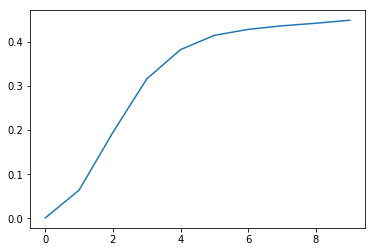

In [18]:
plt.plot(nmi2)
plt.show()

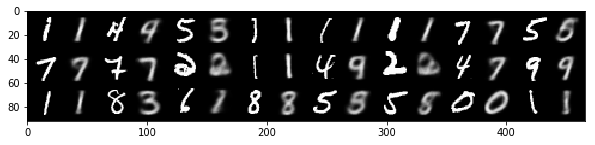

In [19]:
plt.figure(figsize=(10,5))
plot_reconstruction(model_G)

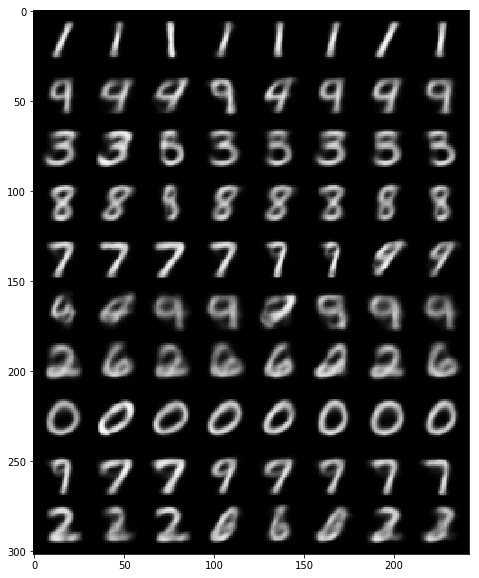

In [20]:
plt.figure(figsize=(10,10))
plot_conditional_generation(model_G, fix_number=None)

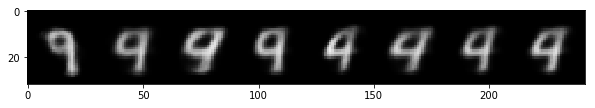

In [22]:
plt.figure(figsize=(10,5))
plot_conditional_generation(model_G, fix_number=1)